In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# Download dataset
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip

# Extract dataset
!unzip -q data.zip

# Check dataset structure
!ls data

--2025-12-03 10:53:43--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-03T11%3A32%3A26Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-03T10%3A31%3A29Z&ske=2025-12-03T11%3A32%3A26Z&sks=b&skv=2018-11-09&sig=xcVpeZQvRB8qv9sfqtEvTnDh4cFH1A5lN7Zdf4d2Le0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDc2MTAyMywibmJmIjoxNzY0NzU5MjIzLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG

In [3]:
# Define transforms WITHOUT augmentation (for first training)
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Same transforms for validation (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='data/test', transform=val_transforms)

# Check class names
print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Create data loaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Classes: ['curly', 'straight']
Train samples: 800
Validation samples: 201


In [4]:
class HairCNN(nn.Module):
    def __init__(self):
        super(HairCNN, self).__init__()

        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu = nn.ReLU()

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate flattened size
        # After conv: (200-3+0)/1 + 1 = 198 -> (32, 198, 198)
        # After pool: 198/2 = 99 -> (32, 99, 99)
        flat_size = 32 * 99 * 99

        # Fully connected layers
        self.fc1 = nn.Linear(flat_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Conv + ReLU + Pool
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # No sigmoid here - we'll use BCEWithLogitsLoss which includes sigmoid
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HairCNN().to(device)

#Question 2
Number of Parameters


In [5]:

!pip install torchsummary -q

from torchsummary import summary

# model summary
summary(model, input_size=(3, 200, 200))

#  manually calculation
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------

Total parameters: 20073473


#Define Loss and Optimizer

Question 1

In [6]:

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

print(f"Using device: {device}")
print(f"Loss function: {criterion}")

Using device: cpu
Loss function: BCEWithLogitsLoss()


In [7]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Shape: (batch_size, 1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training metrics
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation metrics
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    print("-" * 50)

Epoch 1/10: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Epoch 1/10
  Train Loss: 0.6665, Train Acc: 0.6112
  Val Loss: 0.6511, Val Acc: 0.6617
--------------------------------------------------


Epoch 2/10: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 2/10
  Train Loss: 0.5702, Train Acc: 0.6787
  Val Loss: 0.6332, Val Acc: 0.6318
--------------------------------------------------


Epoch 3/10: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Epoch 3/10
  Train Loss: 0.5207, Train Acc: 0.7350
  Val Loss: 0.6143, Val Acc: 0.6766
--------------------------------------------------


Epoch 4/10: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


Epoch 4/10
  Train Loss: 0.4773, Train Acc: 0.7600
  Val Loss: 0.6049, Val Acc: 0.6617
--------------------------------------------------


Epoch 5/10: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Epoch 5/10
  Train Loss: 0.4606, Train Acc: 0.7550
  Val Loss: 0.7307, Val Acc: 0.5672
--------------------------------------------------


Epoch 6/10: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Epoch 6/10
  Train Loss: 0.3954, Train Acc: 0.8275
  Val Loss: 0.6412, Val Acc: 0.6866
--------------------------------------------------


Epoch 7/10: 100%|██████████| 40/40 [00:47<00:00,  1.20s/it]


Epoch 7/10
  Train Loss: 0.2844, Train Acc: 0.8838
  Val Loss: 0.8307, Val Acc: 0.6816
--------------------------------------------------


Epoch 8/10: 100%|██████████| 40/40 [00:48<00:00,  1.20s/it]


Epoch 8/10
  Train Loss: 0.2885, Train Acc: 0.8788
  Val Loss: 0.7052, Val Acc: 0.7114
--------------------------------------------------


Epoch 9/10: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Epoch 9/10
  Train Loss: 0.1882, Train Acc: 0.9313
  Val Loss: 0.9275, Val Acc: 0.6866
--------------------------------------------------


Epoch 10/10: 100%|██████████| 40/40 [00:56<00:00,  1.40s/it]


Epoch 10/10
  Train Loss: 0.2585, Train Acc: 0.8912
  Val Loss: 0.8158, Val Acc: 0.6915
--------------------------------------------------


#Question 3 AND 4

In [8]:
# Convert to numpy arrays for calculations
train_acc = np.array(history['acc'])
train_loss = np.array(history['loss'])

# Question 3: Median of training accuracy
median_acc = np.median(train_acc)
print(f"Q3 - Median training accuracy: {median_acc:.4f}")

# Question 4: Standard deviation of training loss
std_loss = np.std(train_loss)
print(f"Q4 - Standard deviation of training loss: {std_loss:.4f}")

Q3 - Median training accuracy: 0.7937
Q4 - Standard deviation of training loss: 0.1462


In [9]:
# Redefine training transforms WITH augmentation
augmented_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create new data loader with augmented transforms
augmented_train_dataset = datasets.ImageFolder(root='data/train', transform=augmented_transforms)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

# Continue training the same model (don't reinitialize)
print("Continuing training with augmentation...")

aug_history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):  # Train for 10 more epochs
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(augmented_train_loader, desc=f'Aug Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Training metrics
    epoch_loss = running_loss / len(augmented_train_dataset)
    epoch_acc = correct_train / total_train
    aug_history['loss'].append(epoch_loss)
    aug_history['acc'].append(epoch_acc)

    # Validation (same as before)
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    aug_history['val_loss'].append(val_epoch_loss)
    aug_history['val_acc'].append(val_epoch_acc)

    print(f"Aug Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    print("-" * 50)

Continuing training with augmentation...


Aug Epoch 1/10: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Aug Epoch 1/10
  Train Loss: 0.6472, Train Acc: 0.6538
  Val Loss: 0.6915, Val Acc: 0.7114
--------------------------------------------------


Aug Epoch 2/10: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


Aug Epoch 2/10
  Train Loss: 0.6190, Train Acc: 0.6475
  Val Loss: 0.6385, Val Acc: 0.6368
--------------------------------------------------


Aug Epoch 3/10: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


Aug Epoch 3/10
  Train Loss: 0.5847, Train Acc: 0.6837
  Val Loss: 0.6114, Val Acc: 0.6667
--------------------------------------------------


Aug Epoch 4/10: 100%|██████████| 40/40 [00:58<00:00,  1.45s/it]


Aug Epoch 4/10
  Train Loss: 0.5553, Train Acc: 0.7137
  Val Loss: 0.5806, Val Acc: 0.6965
--------------------------------------------------


Aug Epoch 5/10: 100%|██████████| 40/40 [00:57<00:00,  1.45s/it]


Aug Epoch 5/10
  Train Loss: 0.5505, Train Acc: 0.7063
  Val Loss: 0.5498, Val Acc: 0.6915
--------------------------------------------------


Aug Epoch 6/10: 100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


Aug Epoch 6/10
  Train Loss: 0.5196, Train Acc: 0.7250
  Val Loss: 0.6419, Val Acc: 0.6617
--------------------------------------------------


Aug Epoch 7/10: 100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


Aug Epoch 7/10
  Train Loss: 0.5300, Train Acc: 0.7212
  Val Loss: 0.5804, Val Acc: 0.6816
--------------------------------------------------


Aug Epoch 8/10: 100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


Aug Epoch 8/10
  Train Loss: 0.5290, Train Acc: 0.7188
  Val Loss: 0.6402, Val Acc: 0.6418
--------------------------------------------------


Aug Epoch 9/10: 100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


Aug Epoch 9/10
  Train Loss: 0.5155, Train Acc: 0.7462
  Val Loss: 0.5433, Val Acc: 0.7164
--------------------------------------------------


Aug Epoch 10/10: 100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


Aug Epoch 10/10
  Train Loss: 0.5102, Train Acc: 0.7488
  Val Loss: 0.5501, Val Acc: 0.7264
--------------------------------------------------


Q5 - Mean validation loss with augmentation: 0.6028
Q6 - Average validation accuracy for last 5 epochs: 0.6856


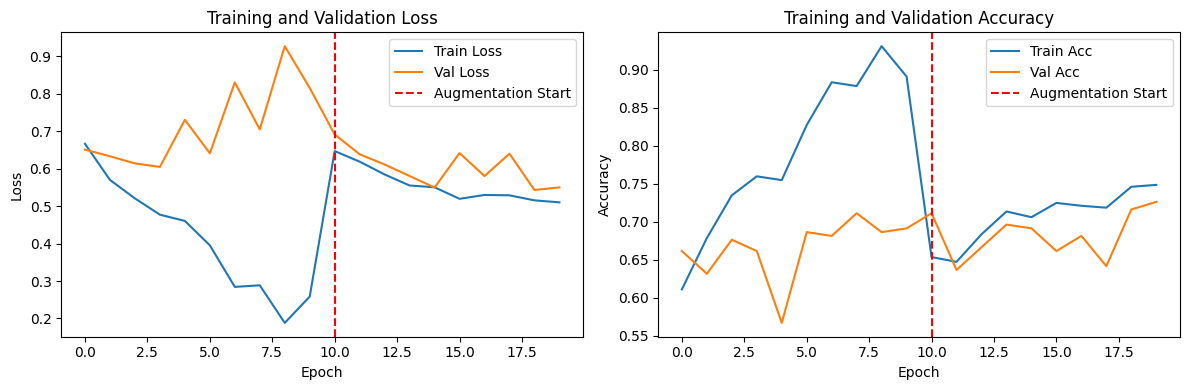

In [10]:
# Convert to numpy arrays
val_loss_aug = np.array(aug_history['val_loss'])
val_acc_aug = np.array(aug_history['val_acc'])

# Question 5: Mean of test loss for all epochs with augmentation
mean_val_loss = np.mean(val_loss_aug)
print(f"Q5 - Mean validation loss with augmentation: {mean_val_loss:.4f}")

# Question 6: Average of test accuracy for last 5 epochs (epochs 6-10)
last_5_acc = val_acc_aug[5:]  # Indices 5,6,7,8,9 for epochs 6-10
avg_last_5_acc = np.mean(last_5_acc)
print(f"Q6 - Average validation accuracy for last 5 epochs: {avg_last_5_acc:.4f}")

# Optional: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'] + aug_history['loss'], label='Train Loss')
plt.plot(history['val_loss'] + aug_history['val_loss'], label='Val Loss')
plt.axvline(x=10, color='r', linestyle='--', label='Augmentation Start')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['acc'] + aug_history['acc'], label='Train Acc')
plt.plot(history['val_acc'] + aug_history['val_acc'], label='Val Acc')
plt.axvline(x=10, color='r', linestyle='--', label='Augmentation Start')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()